In [1]:
## Use this if no GPU is present, run on CPU

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
## Import and define libraries

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

from util.ImgUtil import load_img_path, imshow, tensor_to_image
from model.layers.ContentExtractor import ContentExtractor
from model.layers.PreprocessInput import PreprocessInput
from model.layers.StyleExtractor import StyleExtractor
from model.layers.StyleContentLoss import StyleContentLoss


In [3]:
## Test GPU

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


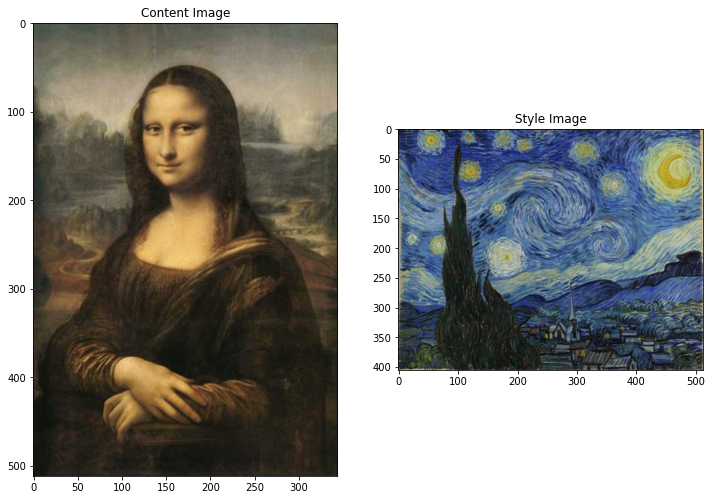

In [4]:
## Import and show images

content_path = tf.keras.utils.get_file('Mona-lisa-blg.jpg', 'https://uploads8.wikiart.org/00339/images/leonardo-da-vinci/mona-lisa-c-1503-1519.jpg!Blog.jpg')
style_path = tf.keras.utils.get_file('starry-night.jpg', 'https://uploads3.wikiart.org/00142/images/vincent-van-gogh/the-starry-night.jpg!Blog.jpg')

content_image = load_img_path(content_path)
style_image = load_img_path(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [5]:
## Create Model Layers

preprocess_input = PreprocessInput()
style_extract = StyleExtractor()
content_extract = ContentExtractor()
style_content_loss = StyleContentLoss()

In [6]:
style_targets = style_extract(preprocess_input.call(style_image))
content_targets = content_extract(preprocess_input.call(content_image))

print('## Styles:')
for name, output in sorted(style_targets.items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("## Contents:")
for name, output in sorted(content_targets.items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

## Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  309.53763
    max:  906211840.0
    mean:  31060516.0

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  6411408400.0
    mean:  987946200.0

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  24679963000.0
    mean:  871248500.0

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  288275460000.0
    mean:  12494675000.0

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  6965317600.0
    mean:  86655656.0

## Contents:
   block5_conv2
    shape:  (1, 32, 21, 512)
    min:  0.0
    max:  309868.22
    mean:  2481.4258


In [7]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [8]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [9]:
total_variation_weight=30

def train_step(image):
    with tf.GradientTape() as tape:
        style_outputs = style_extract(preprocess_input(image))
        content_outputs = content_extract(preprocess_input(image))
        loss = style_content_loss(style_outputs, content_outputs, style_targets, content_targets)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

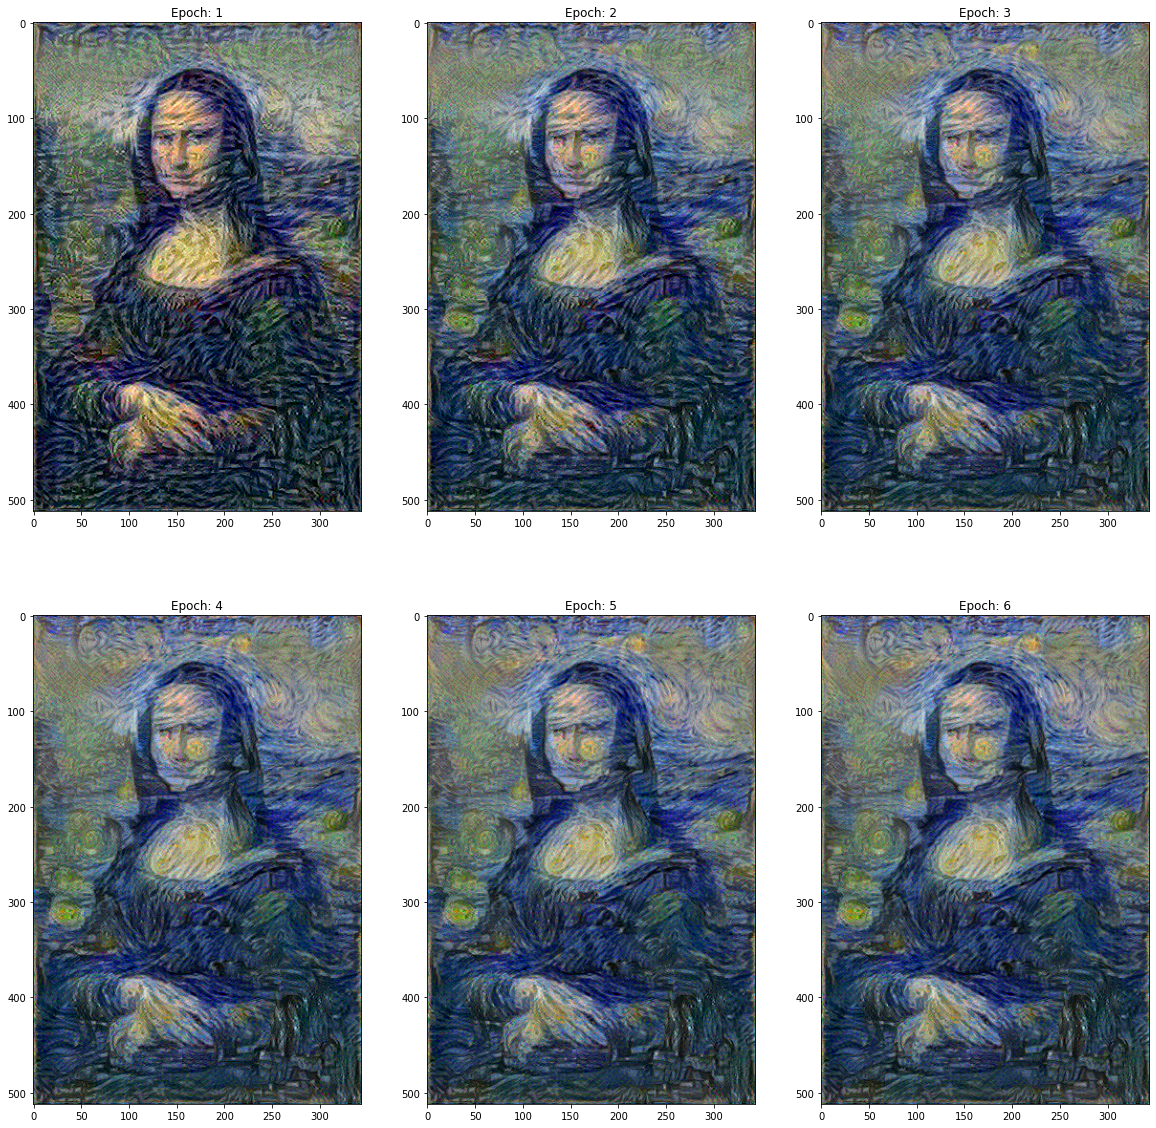

In [10]:
image = tf.Variable(content_image)


epochs = 6
steps_per_epoch = 100
plt.figure(figsize=(20, 20))

step = 0
for n in range(1, epochs + 1):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    plt.subplot(2, 3, n)
    imshow(image, "Epoch: " + str(n))

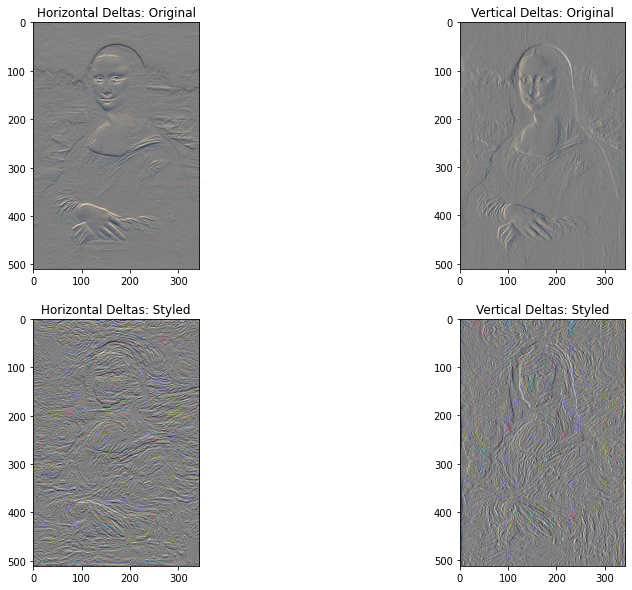

In [11]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")